<a href="https://colab.research.google.com/github/ahneekgyun/Vit_practice/blob/main/ViT_form_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.10.12


In [2]:
import torch
torch.__version__

'2.2.1+cu121'

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
#구글 드라이브 마운트

In [6]:
# 디렉토리 설정
train_dir = '/content/drive/MyDrive/my_data/ViT_practice/train'
test_dir = '/content/drive/MyDrive/my_data/ViT_practice/test'

Datasets와 Dataloaders만들기

In [7]:
# 필요한 모듈 불러오기

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader


Num_workers = os.cpu_count()
print(Num_workers)

16


In [8]:
'''
:str 같은 표기는 가독성을 위한 것임. 프로그램적 제한은 없지만 input의 형태를 지정함으로 코드 가독성이 증가

transforms.Compose는 torchvision.transforms 모듈에서 제공하는 클래스임. 이미지 변환을 조합하여 적용할때 사용함

ImageFolder는 torchvision.datasets 모듈에서 제공하는 클래스임. 디렉토리구조에 기반하여 이미지 데이터셋을 로드함.
이미지데이터가 있는 디렉토리의 경로를 지정해주는데 이 경로에는 클래스별 하위 디렉토리가 있어야함.
대표적인 속성
'root' : 데이터셋이 로드된 디렉토리의 경로를 나타냄
'imgs' : 데이터셋에 포함된 이미지들의 대한 정보를 담는 리스트, 각 요소는 이미지의 경로와 해당 이미지 클래스 레이블을 튜플로 갖는다
'class_to_idx' : 클래스 이름과 해당 클래스의 인덱스를 매핑한 딕셔너리.
'classes' : 클래스의 목록을 가져옴

pin_memory : GPU를 활용해 데이터를 더 빠르게 주고 받는 옵션, 메모리를 고정시키는 것. 많은 메모리가 사용될수 있음주의

''';

In [9]:
# 데이터로더 만들기

def create_dataloader(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers : int=Num_workers
):
  # ImageFolder를 사용하여 데이터셋 만들기
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # 클래스 이름 불러오기
  class_names = train_data.classes

  # data Loaders로 변환하기
  train_dataloader = DataLoader(
      train_data,
      batch_size = batch_size,
      shuffle = True,
      num_workers = num_workers,
      pin_memory = True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size = batch_size,
      shuffle = False,
      num_workers = num_workers,
      pin_memory = True,
  )

  return train_dataloader, test_dataloader, class_names

In [10]:
# 이미지 사이즈 수동으로 조정하기

# 이미지 해상도 지정
IMG_SIZE = 224

# transform pipline구축하기
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),

])
print(f'수동 이미지 조율 : {manual_transforms}')

수동 이미지 조율 : Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [11]:
# 배치사이즈 지정
BATCH_SIZE = 32

# 데이터로더(data Loaders) 만들기
train_dataloader, test_dataloader, class_names = create_dataloader(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

print(train_dataloader)
print(test_dataloader)
print(class_names[:5])

['Bush Clock Vine', 'Common Lanthana', 'Datura', 'Hibiscus', 'Jatropha']


In [12]:
print(train_dataloader.dataset)

Dataset ImageFolder
    Number of datapoints: 4531
    Root location: /content/drive/MyDrive/my_data/ViT_practice/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


데이터셋이 잘 만들어졌는지 확인해보기

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([3, 224, 224]) tensor(21)


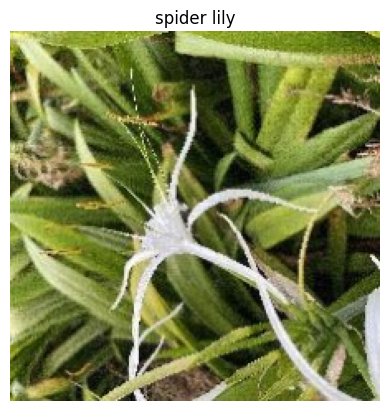

In [15]:
# train_dataloader를 반복가능한 객체로 만든후 next로 불러오기.
# train_dataloader가 가지고 있는 두 가지 속성을 각각 image_batch, label_batch에 저장
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[25], label_batch[25]

print(image.shape, label)

plt.imshow(image.permute(1,2,0))  # 이미지는 보통(높이,너비,채널)로 표현함. 하지만 파이토치는(채널,높이,너비) 사용
                                  # 차원을 바꾸기위해 permute를 사용
plt.title(class_names[label])
plt.axis(False);

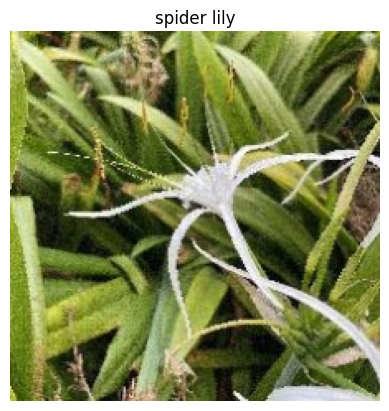

In [16]:
# permute순서를 바꾸면 가로 높이가 반전된 그림이 출력됨을 알 수 있다.
plt.imshow(image.permute(2,1,0))
plt.title(class_names[label])
plt.axis(False);

## Step1

Tasks:

1. 이미지를 패치로 나누기
2. 패치를 flatten시키기
3. 우리가 원하는 결과로 전환하기 -> (196, 768)의 결과를 -> (1, 768, 196) -> (196, 1, 768)로 만들어야함

In [ ]:
'''
nn.Module 에 대하여
-> 사용자가 모델을 만들기 위해 여러가지 편리한 기능을 제공함
1. 모델 구조 정의 : 다양한 layer를 조합해 모델을 구현 할 수 있음
2. 파라미터관리 : 학습가능한 파라미터를 추적하고 관리함
3. 순전파정의 : forward 메서드를 구현해 입력데이터를 모델에 전달하고 출력 계산함.
4. 모델 저장 및 불러오기 : nn.Moudle을 상속한 모델은 state_dict를 통해 모델의 상태 저장, 불러오기 가능
5. 추론모드 및 학습모드 : 모델 클래스에서 .train(), .eval() 메서드를 사용해 학습, 추론모드 전환가능
                     학습중에는 드롭아웃과 같은 정규화 기법 적용가능

nn.Conv2d 에 대하여
-> 컨볼루션연산을 수행하는 레이어임
in_channels: 입력 채널의 수를 나타내는 매개변수. 입력 이미지의 채널 수와 일치해야 함
out_channels: 출력 채널의 수를 나타내는 매개변수. 필터의 개수를 결정하고, 출력으로 생성될 특징 맵의 채널 수를 지정
kernel_size: 컨볼루션 커널의 크기를 나타냄. 높이x너비의 정수 or 튜플형태.
stride: 컨볼루션 연산의 스트라이드
padding: 패딩크기 설정 매개변수
''';

In [13]:
# 1. 이미지를 패치로 나누기
class PatchEmbedding(nn.Module):
  '''2차원 이미지를 1차원 시퀀스로 바꾼다.

  Args:
    in_channels (int) : 입력 이미지의 컬러 채널의 수 이다. 기본값 : 3
    patch_size (int) : 패치들의 사이즈이다. 기본값 : 16
    embedding_dim (int) : 임베딩의 크기이다. 기본값 : 768
  '''

  # 2. 초기값 설정
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()

    # 3. 이미지를 패치로 바꾸는 레이어 생성

    # 컨볼루션을 활용해서 패치로 나눔.
    # 16필터를 사용하고 stride=16, 768차원 결과를 설정하면된다.
    # 결과는 14x14x768의 차원으로 나올 것
    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels = embedding_dim,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding = 0
                             )

    # 4. 패치를 1차원 으로 flatten시키는 레이어 만들기
    # start : 2번째 부터 end : 3번째 차원을 평탄화 한다.
    # 차원은 주로 [배치사이즈, 채널, W , H]로 구성되어 있다.
    self.flatten = nn.Flatten(start_dim = 2,
                               end_dim = 3)

  # 5. forward 방법 정하기
  def forward(self, x):
    # 알맞은 차원으로 되었는지 확인하는 코드 넣기
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f'Input imgae size ust be divisble by patch size, image shpae: {image_resolution}'

    # forward pass 실행
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    return x_flattened.permute(0,2,1)

In [17]:
patch_size = 16

def set_seed(seed: int=42):

  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

set_seed()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim = 768)

# unsqueeze(0), 가장 앞에 새로운 차원 추가하기
# 배치사이즈를 추가하여 입력 형태를 맞춰주기 위함임
print(image.unsqueeze(0).shape)
patch_embedded_image = patchify(image.unsqueeze(0))
print(patch_embedded_image.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 196, 768])


In [18]:
# 패치 임베딩과 형태 확인하기

print(patch_embedded_image)
print(patch_embedded_image.shape)

tensor([[[-0.9391,  0.2627, -0.2314,  ...,  0.5653, -0.3397,  0.0916],
         [-0.4128,  0.0441, -0.2097,  ...,  0.3094, -0.2817,  0.2623],
         [-0.4478,  0.1985, -0.1950,  ...,  0.4073, -0.2792,  0.0682],
         ...,
         [-0.9464,  0.2007,  0.0166,  ...,  0.6015, -0.3505,  0.3005],
         [-0.2782,  0.0372, -0.4397,  ...,  0.3788, -0.2517,  0.6496],
         [-0.7934,  0.3480, -0.0661,  ...,  0.3670, -0.2039, -0.1594]]],
       grad_fn=<PermuteBackward0>)
torch.Size([1, 196, 768])


In [19]:
# class 임베딩과 position 임베딩 수행하기

set_seed()

# 1. 패치사이즈 설정
patch_size = 16

# 2. 원본 이미지 출력하고 이미지의 차원얻기
print(f'Image tensor shape: {image.shape}')
height, width = image.shape[1], image.shape[2]

# 3. 이미지 텐서에 배치차원 추가하기
x = image.unsqueeze(0)
print(f'Input image with batch dimension shape: {x.shape}')

# 4. 임베딩 레이어 생성
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size = patch_size,
                                       embedding_dim = 768)

# 5. 임베딩 레이어 통과시키기
patch_embedding = patch_embedding_layer(x)
print(f'Patch embedding shape: {patch_embedding.shape}')

# 6. 클래스 토큰 임베딩 만들기
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True)
print(f'Class token embedding shape : {class_token.shape}')

# 7. 패치 임베딩에 클래스 임베딩 합치기
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim = 1)
print(f'Patch embedding with class token shape: {patch_embedding_class_token.shape}')

# 8. 포지션 임베딩 만들기
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension,
                                             requires_grad = True))

# 9. 포지션임베딩을 합치기
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'Patch and position embedding shape : {patch_and_position_embedding.shape}')

print(patch_embedding_class_token)


Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape : torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape : torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9391,  0.2627, -0.2314,  ...,  0.5653, -0.3397,  0.0916],
         [-0.4128,  0.0441, -0.2097,  ...,  0.3094, -0.2817,  0.2623],
         ...,
         [-0.9464,  0.2007,  0.0166,  ...,  0.6015, -0.3505,  0.3005],
         [-0.2782,  0.0372, -0.4397,  ...,  0.3788, -0.2517,  0.6496],
         [-0.7934,  0.3480, -0.0661,  ...,  0.3670, -0.2039, -0.1594]]],
       grad_fn=<CatBackward0>)


In [20]:
# 1. nn.Module에서 class 만들기

class MultiheadSelfAttentionBlock(nn.Module):
  ''' 멀티헤드셀프어텐션 블럭을 만든다. MSA블럭
  '''

  # 클래스를 초기값설정
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               attn_dropout:float=0):
    super().__init__()

    # 3. Norm Layer만들기
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

    # 4. MSA Layer만들기
    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                num_heads = num_heads,
                                                dropout = attn_dropout,
                                                batch_first = True) # 배치 차원이 먼저 오는지 여부

  # 5. forward() 만들기
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output,_ = self.multihead_attn(query = x,
                                          key = x,
                                          value=x,
                                          need_weights = False)
    return attn_output

MLP 블럭

In [21]:
# 1. 클래스 정의하기
class MLPBlock(nn.Module):

  # 2. 초기설정
  def __init__(self,
               embedding_dim :int=768,
               mlp_size:int=3072,
               dropout:float=0.1):
    super().__init__()

    # 3. Norm Layer만들기
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

    # 4. MLP Layer만들기
    self.mlp = nn.Sequential(
        nn.Linear(in_features= embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  # 5. 포워드 만들기
  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [22]:
class TransformerEncoderBlock(nn.Module):

  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:int=3072,
               mlp_dropout:float=0.1,
               attn_dropout:float=0):
    super().__init__()

    # 3. MSA블럭 만들기
    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim = embedding_dim,
                              num_heads=num_heads,
                              attn_dropout=attn_dropout)
    # 4. MLP블럭 만들기
    self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

    # 5.래포웓
  def forward(self, x):

    #6. Residual connection
    x = self.msa_block(x) + x

    # 7. Resis for MLP
    x = self.mlp_block(x) + x

    return x

In [23]:
!pip install torchinfo

In [24]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary

summary(model = transformer_encoder_block,
        input_size = (1,197,768),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width = 20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [25]:
class ViT(nn.Module):

  def __init__(self,
               img_size:int=224,
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,
               embedding_dim:int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout:float=0.1,
               mlp_dropout:float=0.1,
               embedding_dropout:float=0.1,
               num_classes:int=1000):
    super().__init__()

    # 3. 이미지가 패치사이즈로 나눠지게 체크
    assert img_size % patch_size == 0, f'Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}'

    # 4. 패치 갯수 구하기
    self.num_patches = (img_size * img_size) // patch_size**2

    # 5. 학습가능한 임베딩구하기
    self.class_embedding = nn.Parameter(data = torch.randn(1, 1, embedding_dim),
                                         requires_grad=True)
    # 6. 포지션 임베딩
    self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches+1, embedding_dim),
                                                        requires_grad = True)

    # 7. 임베딩 드랍아웃
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # 8. 패치 임베딩 레이어 만들기
    self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                           patch_size = patch_size,
                                           embedding_dim = embedding_dim)

    # 9. 트랜스포머 인코더 만들기
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                        num_heads=num_heads,
                                                                        mlp_size = mlp_size,
                                                                        mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    # 10. 클래스 헤드
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape = embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )
  # 11. forward
  def forward(self, x):

    # 배치사이즈
    batch_size = x.shape[0]

    # 13. 클래스 토큰임베딩
    class_token = self.class_embedding.expand(batch_size, -1, -1)

    # 14. 배치임베딩
    x = self.patch_embedding(x)

    # 15. 패치 클래스 컨켓
    x = torch.cat((class_token, x), dim=1)

    # 16. 포지션 임베딩
    x = self.position_embedding + x

    # 17. 드롭아웃
    x = self.embedding_dropout(x)

    # 18. 패치, 포지션 클래스 임베딩 다 넘어가기
    x = self.transformer_encoder(x)

    # 19. 클래스 토큰 로짓에 넣기
    x = self.classifier(x[:, 0])

    return x

In [26]:
vit = ViT(num_classes = len(class_names))

In [27]:
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 43.24 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [29]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params = vit.parameters(),
                             lr = 1e-4,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

set_seed()

results = engine.train(model=vit,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs=10,
                       device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.3585 | train_acc: 0.0513 | test_loss: 3.3563 | test_acc: 0.0387
Epoch: 2 | train_loss: 3.3464 | train_acc: 0.0424 | test_loss: 3.3565 | test_acc: 0.0357
Epoch: 3 | train_loss: 3.3440 | train_acc: 0.0482 | test_loss: 3.3448 | test_acc: 0.0357
Epoch: 4 | train_loss: 3.3404 | train_acc: 0.0455 | test_loss: 3.3376 | test_acc: 0.0357
Epoch: 5 | train_loss: 3.3365 | train_acc: 0.0435 | test_loss: 3.3467 | test_acc: 0.0432
Epoch: 6 | train_loss: 3.3387 | train_acc: 0.0481 | test_loss: 3.3419 | test_acc: 0.0357
Epoch: 7 | train_loss: 3.3350 | train_acc: 0.0415 | test_loss: 3.3443 | test_acc: 0.0432
Epoch: 8 | train_loss: 3.3370 | train_acc: 0.0447 | test_loss: 3.3489 | test_acc: 0.0432
Epoch: 9 | train_loss: 3.3340 | train_acc: 0.0492 | test_loss: 3.3456 | test_acc: 0.0312
Epoch: 10 | train_loss: 3.3296 | train_acc: 0.0491 | test_loss: 3.3361 | test_acc: 0.0432


In [33]:
import requests

In [34]:
from going_modular.going_modular.predictions import pred_and_plot_image

In [37]:
custom_image_path = '/content/drive/MyDrive/my_data/ViT_practice/test/Bush Clock Vine/Bush_Clock_Vine100_jpg.rf.0acb3922bce6bf1ff0ee68243d216976.jpg'

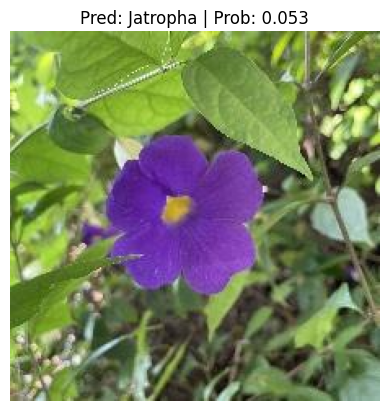

In [38]:
pred_and_plot_image(model = vit,
                    image_path =custom_image_path,
                    class_names = class_names)